In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
    library(edgeR)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen2"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    save_seurat_h5 = "YES"
    de_testing = "NEIGHBORHOOD"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as target_positive, all others as target_negative

In [6]:
# mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
#     all_cells = Cells(seurat_obj)
#     perturbed_cells = c()
#     dummy_perturbed = c()
    
#     for(guide in guides) {
#         dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
#         perturbed_cells = union(perturbed_cells, dummy_perturbed)
#         #cat(guide," ", length(perturbed_cells), "\n")
#     }

#     unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
#     Idents(seurat_obj) <- "target_negative"
#     seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "target_positive") 

#     if(print_counts) {
#         n_gplus   = length(perturbed_cells)
#         n_gminus = length(unperturbed_cells)    
#         cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
#     }
    
#     seurat_obj
# }

### Load guide df

In [7]:
if(prj_name == "Screen1") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
    neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/neighbors_list.rds")
} else if(prj_name == "Screen2") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
    neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/neighbors_list.rds")
}

sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE
rs9529913,DE24-2a,DE24-2b,DE24,ckd_de,targeting,rs9529913,CKD DE
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE
C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting,C15orf40,Control TSS
rs881858,DE9-2a,DE9-2b,DE9,ckd_de,targeting,rs881858,CKD DE


### Load Seurat file

In [8]:
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file



Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [ ]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [ ]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [ ]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [ ]:
THRESHOLD_MULTIPLIER = 1
cat(red("Using ", THRESHOLD_MULTIPLIER, "x threshold"))

perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = THRESHOLD_MULTIPLIER * df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

Using 3x threshold

In [ ]:
length(perturbed_cells_by_guide[[3]])

[1] 301

In [ ]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a" "NTCE4-1b"

# Check DE for genes near SNPs

In [ ]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

* * * * *
I skip DE 20 because it doesn't have a rsID. Use it's coords instead 
* * * * *

# Run diffex on pseudobulked samples using DESeq2

In [ ]:
# df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
# df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
# df_neighbor_de = NULL
# test_use = "LR" #"MAST"  #"wilcox" "LR"
# guides_to_skip = c()  #c("DE6", "DE15")  
# logfc_threshold = 0.01


# for(i in 1:nrow(df_targets)) {
#     i = 28
#     target          = df_targets[i,'alias']
#     target_subclass = df_targets[i, 'subclass']
#     label           = df_targets[i, 'label']
#     snp_id_or_gene_name = df_targets[i,'gene']
    
#     if(!str_detect(target, regex("^DE\\d+$"))) {
#         ckd_de = 
#         neighbors = neighbors_list[[target]]
#     } else {
#         neighbors = neighbors_list[[snp_id_or_gene_name]]
#     }

#     if((target %in% guides_to_skip) | length(neighbors) == 0 ){
#         cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
#         next
#     }
#     guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
#     cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
#     seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
#     seurat_dummy$psbulk_replicate_id = Idents(seurat_dummy)
#     seurat_dummy$psbulk_replicate_id = paste0(seurat_dummy$psbulk_replicate_id, "_", seurat_dummy$donor)
#     Idents(seurat_dummy) = seurat_dummy$psbulk_replicate_id

#     counts <- AggregateExpression(
#         seurat_dummy,            
#         assays = 'RNA',
#         slot = "counts",
#         return.seurat = FALSE
#     )
#     #
#     break
# }


In [ ]:
# df_counts <- as.data.frame(counts$RNA)
# df_counts <- df_counts[, sort(colnames(df_counts))]
# head(df_counts, 20)

In [ ]:
# col_data = data.frame(c(rep(c("Control"),4), rep(c("Stimulated"),4)))
# rownames(col_data) = colnames(df_counts)
# colnames(col_data) = "condition"
# col_data

In [ ]:
# # Create DESeq2 object   
# library(DESeq2)
# dds <- DESeqDataSetFromMatrix(
#     countData = df_counts,
#     colData = col_data,
#     design = ~ condition
# )

In [ ]:
# keep <- rowSums(counts(dds)) >=5
# dds <- dds[keep,]

In [ ]:
# # run DESeq2
# dds <- DESeq(dds, )

In [ ]:
# plotDispEsts(dds)

In [ ]:
# resultsNames(dds)

In [ ]:
# # Generate results object
# #res <- results(dds, name = "condition_Stimulated_vs_Control")
# res <- results(dds, contrast=c("condition","Control", "Stimulated"))
# res

# Run diffex on pseudobulked samples using EdgeR

This version ran DE testing on all genes. If you want to include only the neighbors, use: markers <- qlf$table[neighbors, ] %>% arrange(PValue)

In [ ]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
df_cell_counts = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01


for(i in 1:nrow(df_targets)) {
    is_de = FALSE
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        is_de = FALSE
        neighbors = neighbors_list[[target]]
    } else {
        is_de = TRUE
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neighbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    seurat_dummy$perturbation_status = Idents(seurat_dummy)
    #seurat_dummy$psbulk_replicate_id = paste0(seurat_dummy$donor, "_", seurat_dummy$perturbation_status)
    #Idents(seurat_dummy) = seurat_dummy$psbulk_replicate_id
    seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
    print(table(filter(seurat_dummy@meta.data, perturbation_status == 'target_positive')$donor) )


    # Use each donor as a replicate
    cluster_list = as.character(seurat_dummy$perturbation_status)
    cluster_list[cluster_list == "target_negative"] = 1
    cluster_list[cluster_list == "target_positive"] = 0
    seurat_dummy$cluster = as.factor(cluster_list)
    y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

    # Add target+/- counts to df_cell_counts
    if(!is_de) {
        df_dummy = as.data.frame(y$counts[target,])
        colnames(df_dummy) = "count"
        df_dummy$target <- target
        df_dummy$label = rownames(df_dummy)
        df_samples = y$samples
        df_dummy = merge(df_dummy, df_samples, by = 0)
        df_cell_counts = rbind(df_cell_counts, df_dummy)
    }

    # Filter out small samples, lowly expressed genes.
    keep.samples <- y$samples$lib.size > 5e4
    table(keep.samples)
    y <- y[, keep.samples]
    keep.genes <- filterByExpr(y, group=y$samples$cluster, min.count=10, min.total.count=20)
    table(keep.genes)
    y <- normLibSizes(y)

    # Create design matrix
    donor <- factor(y$samples$sample)
    cluster <- as.factor(y$samples$cluster)
    design <- model.matrix(~ cluster + donor)
    colnames(design) <- gsub("donor", "", colnames(design))
    colnames(design)[1] <- "Int"

    ncls <- nlevels(cluster)
    contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
    diag(contr) <- 1
    contr[1,] <- 0
    rownames(contr) <- colnames(design)
    colnames(contr) <- paste0("cluster", levels(cluster))
    
    # Estimate dispersion
    y <- estimateDisp(y, design, robust=TRUE)
    y$common.dispersion

    # Fit
    fit <- glmQLFit(y, design, robust=TRUE)
    qlf <- glmQLFTest(fit, contrast=contr[,1])
    
    if(de_testing == "NEIGHBORHOOD") {
        markers <- qlf$table[neighbors, ] %>% arrange(PValue)
    } else { 
        # Test all genes
        markers <- qlf$table %>% arrange(PValue)
    }
    
    

    markers$de_gene = rownames(markers)
    markers$target = target
    markers$subclass = target_subclass
    markers$label = label
    rownames(markers) <- NULL
    df_neighbor_de = rbind(df_neighbor_de, markers)
    print(head(markers))
    cat("-------------------------------------------------------\n\n")
}


ANPEP ANPEP : CD13-1a,CD13-1b 
CD13-1a   390 
CD13-1b   564 
Guide+ = 564 ; Guide- = 45487 

donor0 donor1 donor2 donor3 
   127    179    145    113 
  logFC logCPM    F  PValue de_gene target subclass       label
1 -0.32    6.9 25.0 5.9e-07  SEMA4B  ANPEP      tss Control TSS
2 -0.18    7.3  9.2 2.4e-03   ANPEP  ANPEP      tss Control TSS
3  0.20    5.2  5.5 1.9e-02   MFGE8  ANPEP      tss Control TSS
4 -0.44    2.7  4.4 3.5e-02  GDPGP1  ANPEP      tss Control TSS
5  0.26    3.7  3.9 4.9e-02   MESP1  ANPEP      tss Control TSS
6 -0.11    7.2  3.3 7.1e-02    IDH2  ANPEP      tss Control TSS
-------------------------------------------------------

CD55 CD55 : CD55-1a,CD55-1b 
CD55-1a   301 
CD55-1b   466 
Guide+ = 466 ; Guide- = 45585 

donor0 donor1 donor2 donor3 
    88    173    112     93 
  logFC logCPM   F PValue  de_gene target subclass       label
1 -0.89  2.200 8.2 0.0041 C1orf116   CD55      tss Control TSS
2 -8.25 -1.483 4.9 0.0267     FCMR   CD55      tss Control TSS
3 -0.1

In [ ]:
df_cell_counts$label = str_replace(df_cell_counts$label, "_cluster0", "(+)")
df_cell_counts$label = str_replace(df_cell_counts$label, "_cluster1", "(-)")

df_cell_counts$norm_count = max(df_cell_counts$lib.size) * df_cell_counts$count/df_cell_counts$lib.size

# options(repr.plot.width=15, repr.plot.height=6)
# ggplot(df_cell_counts, aes(label)) +
#     geom_bar(aes(weight=norm_count)) +
#     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 13)) +
#     facet_wrap(~ target, scales="free", ncol = 7)


options(repr.plot.width=20, repr.plot.height=12)
ggplot(df_cell_counts, aes(x = label, y = norm_count, fill = sample))+
     geom_bar(position="stack", stat="identity")  +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 13)) +
    facet_wrap(~ vector, scales="free", ncol = 7)

df_cell_counts_only_plus_minus = df_cell_counts %>% filter()

ERROR: Error in str_replace(df_cell_counts$label, "_cluster0", "(+)"): could not find function "str_replace"


## Inpect DE results

Print top high-confidence hits

In [ ]:
df_neighbor_de %>% filter(logFC < 0) %>% arrange(PValue) %>% head(25)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-0.45,5.8,86,1.6e-20,ASRGL1,FTH1,de_control,Control DE
2,-1.27,3.8,72,2.1e-17,TFAP2B,DE16,ckd_de,CKD DE
3,-0.50,6.6,69,8.6e-17,PKHD1,DE16,ckd_de,CKD DE
4,-1.07,3.8,66,1.9e-15,AOC1,DE17,ckd_de,CKD DE
5,-0.67,4.1,54,1.7e-13,CHST9,DE5,ckd_de,CKD DE
6,-0.27,8.7,43,5.8e-11,RBPMS,DE15,ckd_de,CKD DE
7,-0.30,6.1,39,5.2e-10,PIK3R1,DE4,ckd_de,CKD DE
8,-0.41,6.7,36,2.1e-09,NT5E,NT5E,tss,Control TSS
9,-0.56,5.1,34,4.7e-09,C15orf40,C15orf40,tss,Control TSS


In [ ]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(logFC < 0) %>% arrange(PValue) %>% head(20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-0.41,6.71,35.8,2.1e-09,NT5E,NT5E,tss,Control TSS
2,-0.56,5.14,34.3,4.7e-09,C15orf40,C15orf40,tss,Control TSS
3,-1.47,3.21,32.6,1.2e-08,PTGFR,FUBP1,tss,Control TSS
4,-0.32,6.86,25.0,5.9e-07,SEMA4B,ANPEP,tss,Control TSS
5,-0.82,3.45,13.9,2.0e-04,ST6GALNAC5,FUBP1,tss,Control TSS
6,-0.33,5.66,11.3,7.7e-04,FUBP1,FUBP1,tss,Control TSS
7,-0.57,3.81,10.8,1.0e-03,MAFF,MAFF,tss,Control TSS
8,-0.23,7.25,10.0,1.5e-03,AK5,FUBP1,tss,Control TSS
9,-0.18,7.27,9.2,2.4e-03,ANPEP,ANPEP,tss,Control TSS


In [ ]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-1.27,3.81,72.1,2.1e-17,TFAP2B,DE16,ckd_de,CKD DE
2,-0.50,6.59,69.3,8.6e-17,PKHD1,DE16,ckd_de,CKD DE
3,-1.07,3.78,66.3,1.9e-15,AOC1,DE17,ckd_de,CKD DE
4,-0.67,4.12,54.4,1.7e-13,CHST9,DE5,ckd_de,CKD DE
5,-0.27,8.68,42.9,5.8e-11,RBPMS,DE15,ckd_de,CKD DE
6,-0.30,6.08,38.6,5.2e-10,PIK3R1,DE4,ckd_de,CKD DE
7,-0.43,5.81,32.7,1.1e-08,VEGFA,DE9,ckd_de,CKD DE
8,-0.37,6.42,30.4,1.1e-06,TMEM176B,DE17,ckd_de,CKD DE
9,0.27,5.89,22.4,2.2e-06,TNFRSF10D,DE7,ckd_de,CKD DE


In [ ]:
df_neighbor_de %>% filter((subclass == 'de_control') & (PValue < 1e-10)) 

logFC,logCPM,F,PValue,de_gene,target,subclass,label
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
-0.45,5.8,86,1.6e-20,ASRGL1,FTH1,de_control,Control DE
0.35,8.8,54,1.8e-13,LGALS3,LGALS3,de_control,Control DE


In [ ]:
#select_significant_p  = df_neighbor_de$PValue < 1
#df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "DE6",], 20)
head(df_neighbor_de[df_neighbor_de$target == "DE15",], 20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
494,-0.113,6.613,5.688,0.017,ST3GAL1,DE6,ckd_de,CKD DE
495,-0.118,4.812,3.140,0.076,KCNQ3,DE6,ckd_de,CKD DE
496,0.565,-1.372,1.482,0.223,HPYR1,DE6,ckd_de,CKD DE
497,-0.307,-0.025,0.817,0.366,CCN4,DE6,ckd_de,CKD DE
498,-0.085,2.966,0.531,0.466,TG,DE6,ckd_de,CKD DE
499,-0.029,7.630,0.433,0.510,NDRG1,DE6,ckd_de,CKD DE
500,0.019,5.952,0.135,0.713,PHF20L1,DE6,ckd_de,CKD DE
501,0.043,0.376,0.024,0.876,SLA,DE6,ckd_de,CKD DE
502,0.051,-0.671,0.017,0.896,TMEM71,DE6,ckd_de,CKD DE


,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
667,-0.268,8.68,42.890,5.8e-11,RBPMS,DE15,ckd_de,CKD DE
668,0.137,6.55,7.812,5.2e-03,PPP2CB,DE15,ckd_de,CKD DE
669,-7.538,-2.18,6.272,1.2e-02,PURG,DE15,ckd_de,CKD DE
670,0.135,5.78,5.693,1.7e-02,LEPROTL1,DE15,ckd_de,CKD DE
671,-0.115,5.93,4.238,4.0e-02,GSR,DE15,ckd_de,CKD DE
672,0.089,6.81,3.549,6.0e-02,SARAF,DE15,ckd_de,CKD DE
673,0.072,5.34,1.288,2.6e-01,DCTN6,DE15,ckd_de,CKD DE
674,-4.915,-4.37,1.046,3.1e-01,LINC02209,DE15,ckd_de,CKD DE
675,0.320,0.38,1.027,3.1e-01,SMIM18,DE15,ckd_de,CKD DE


## Volcano Plot

In [ ]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


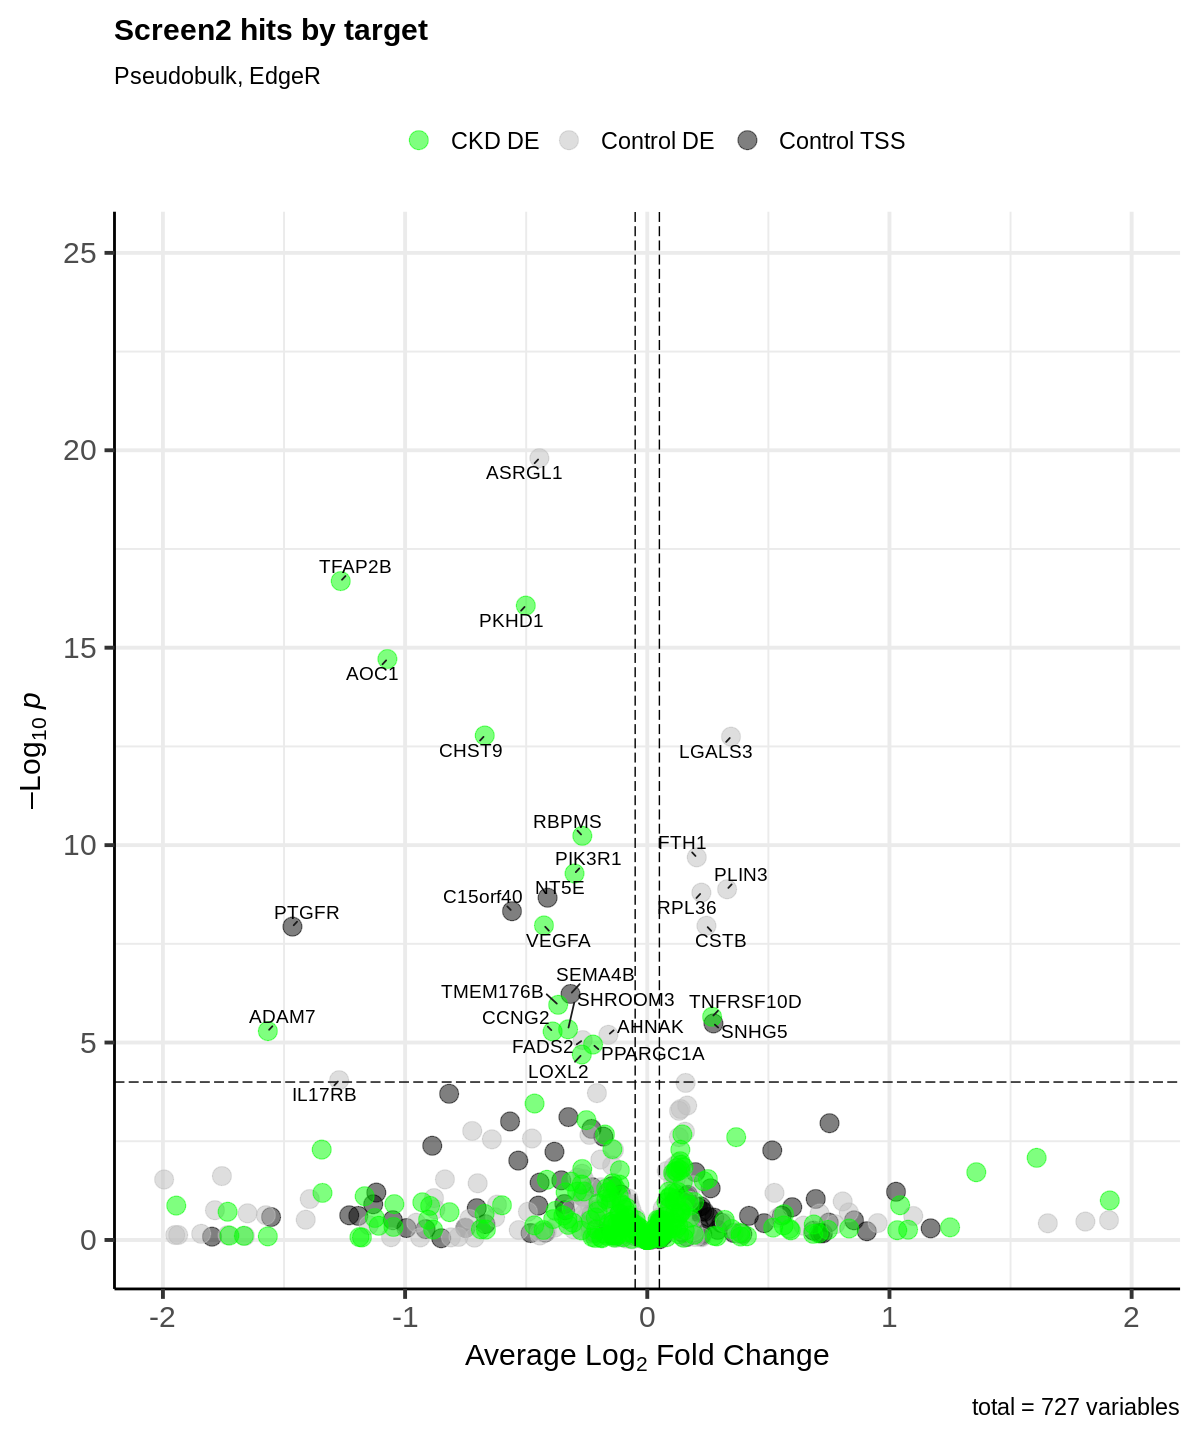

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, "hits by target"),
                subtitle = 'Pseudobulk, EdgeR', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

### Plot just the control TSS

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


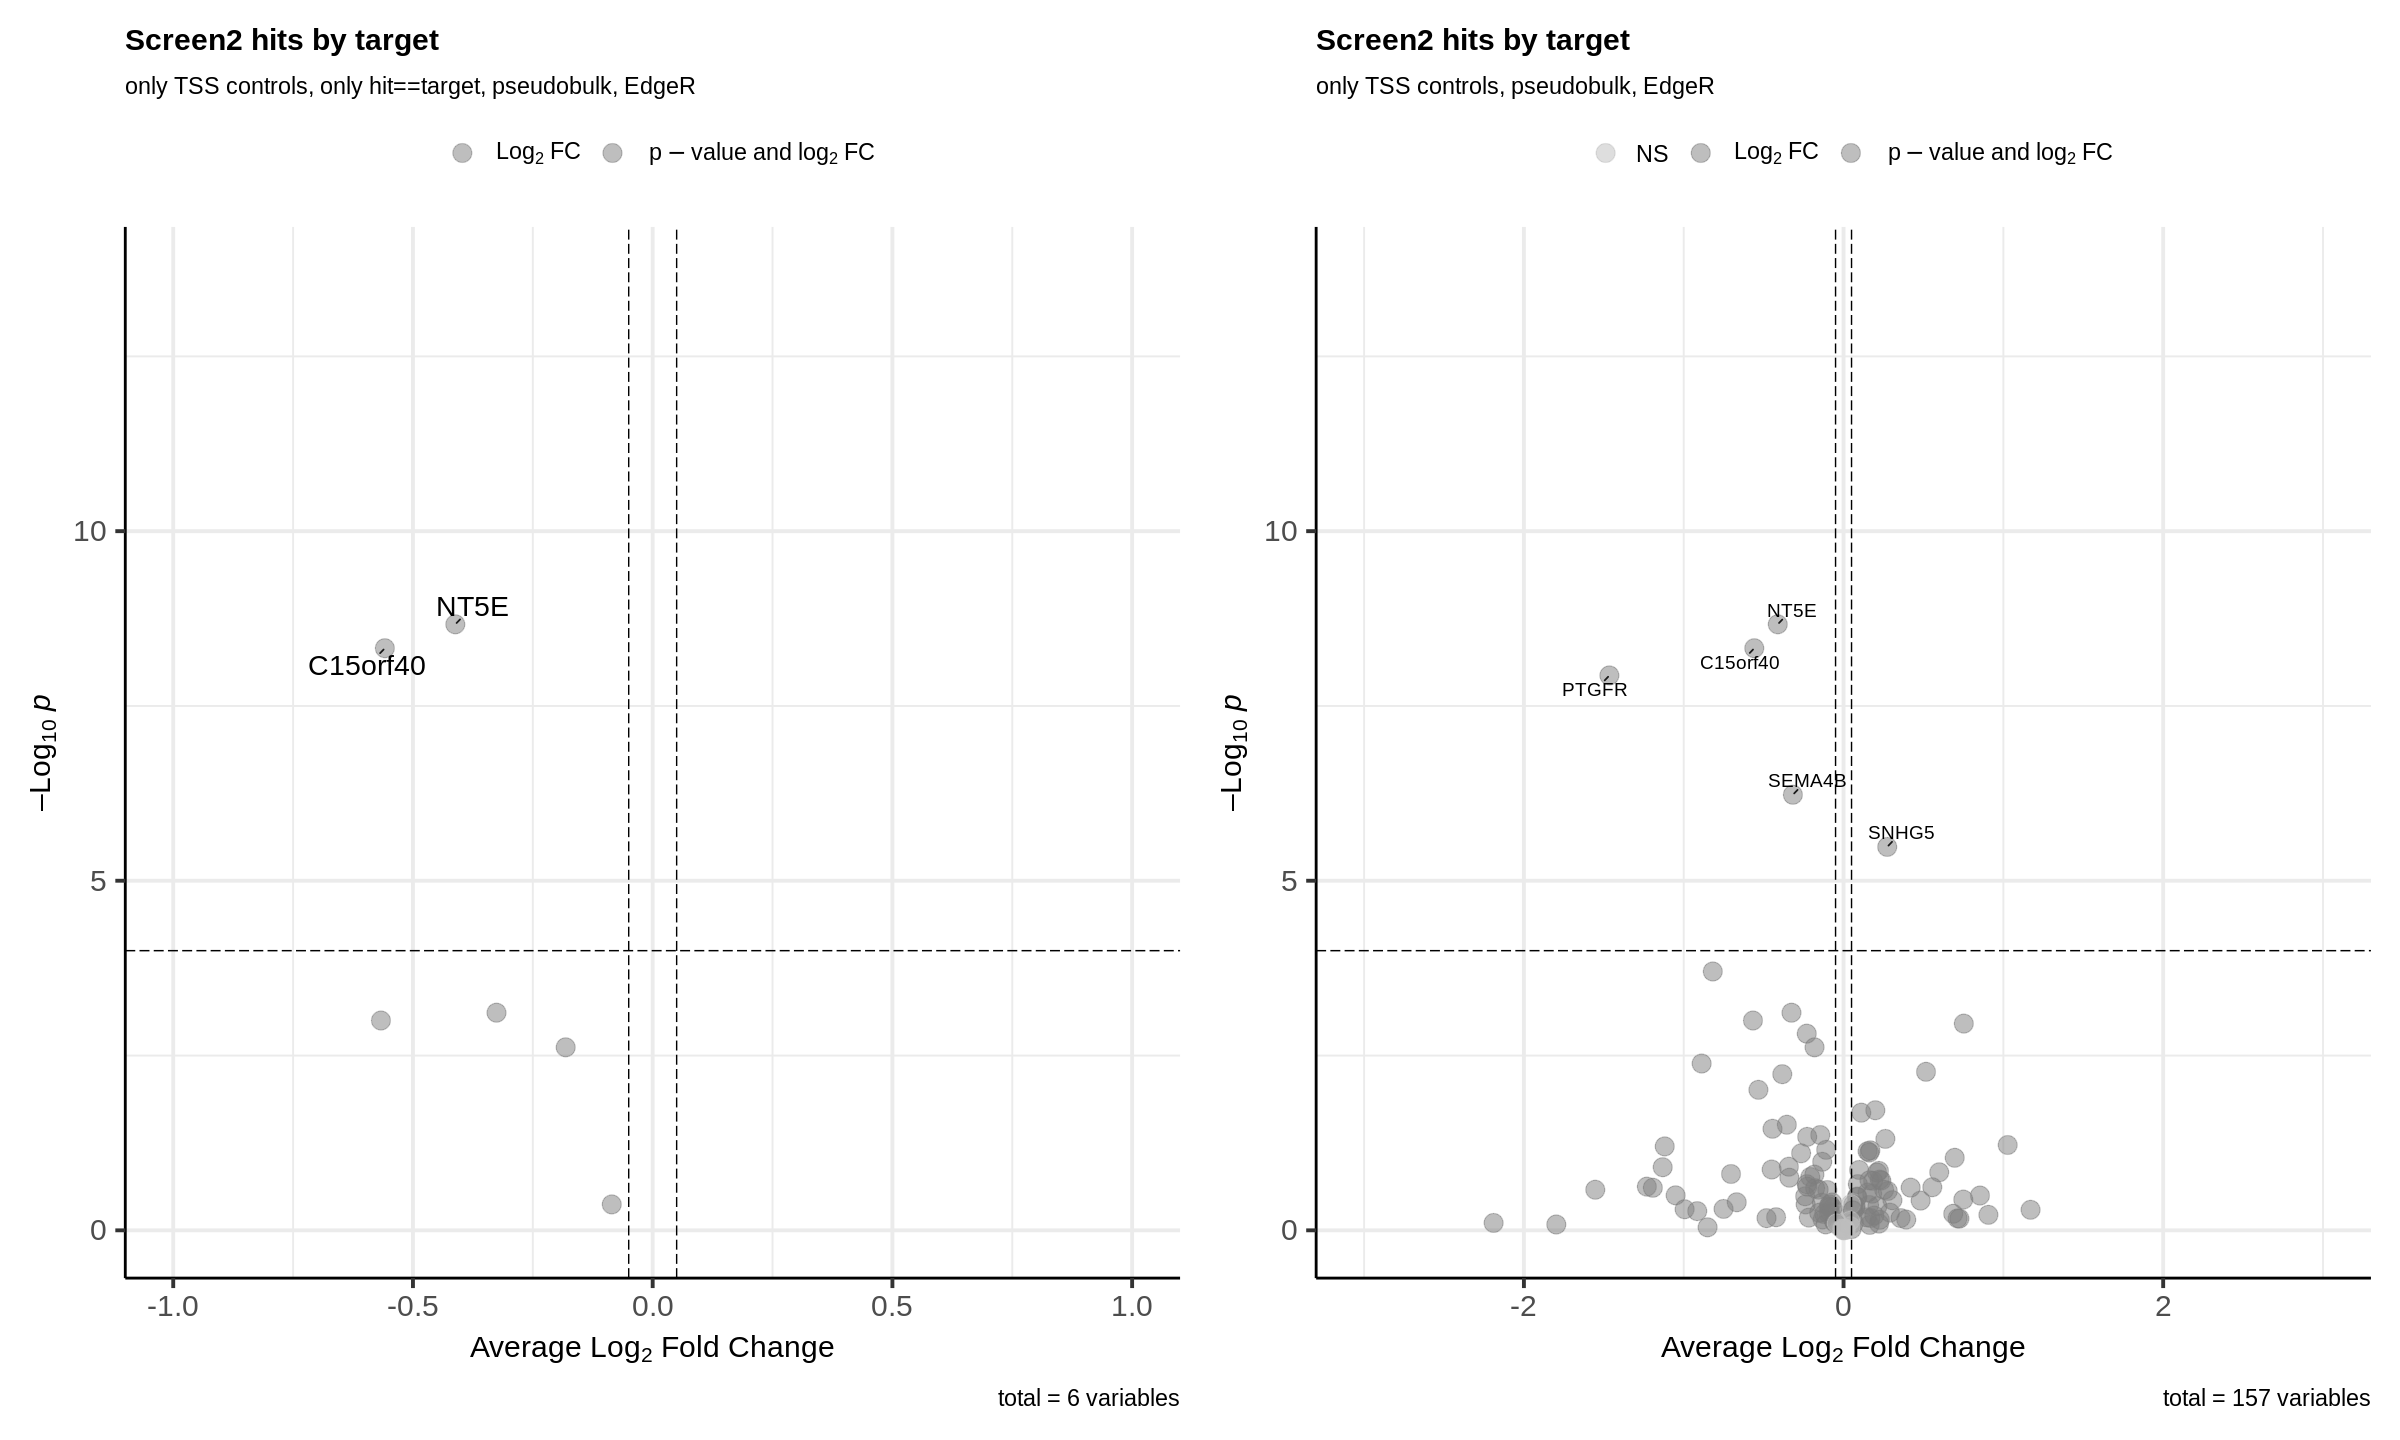

In [ ]:
de_filter = (df_neighbor_de$subclass == 'tss') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only TSS controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-1, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'tss')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only TSS controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-3, 3) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

In [ ]:
head(df_neighbor_de_subset)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-0.32,6.9,25.0,5.9e-07,SEMA4B,ANPEP,tss,Control TSS
2,-0.18,7.3,9.2,2.4e-03,ANPEP,ANPEP,tss,Control TSS
3,0.20,5.2,5.5,1.9e-02,MFGE8,ANPEP,tss,Control TSS
4,-0.44,2.7,4.4,3.5e-02,GDPGP1,ANPEP,tss,Control TSS
5,0.26,3.7,3.9,4.9e-02,MESP1,ANPEP,tss,Control TSS
6,-0.11,7.2,3.3,7.1e-02,IDH2,ANPEP,tss,Control TSS


### Plot just the control DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


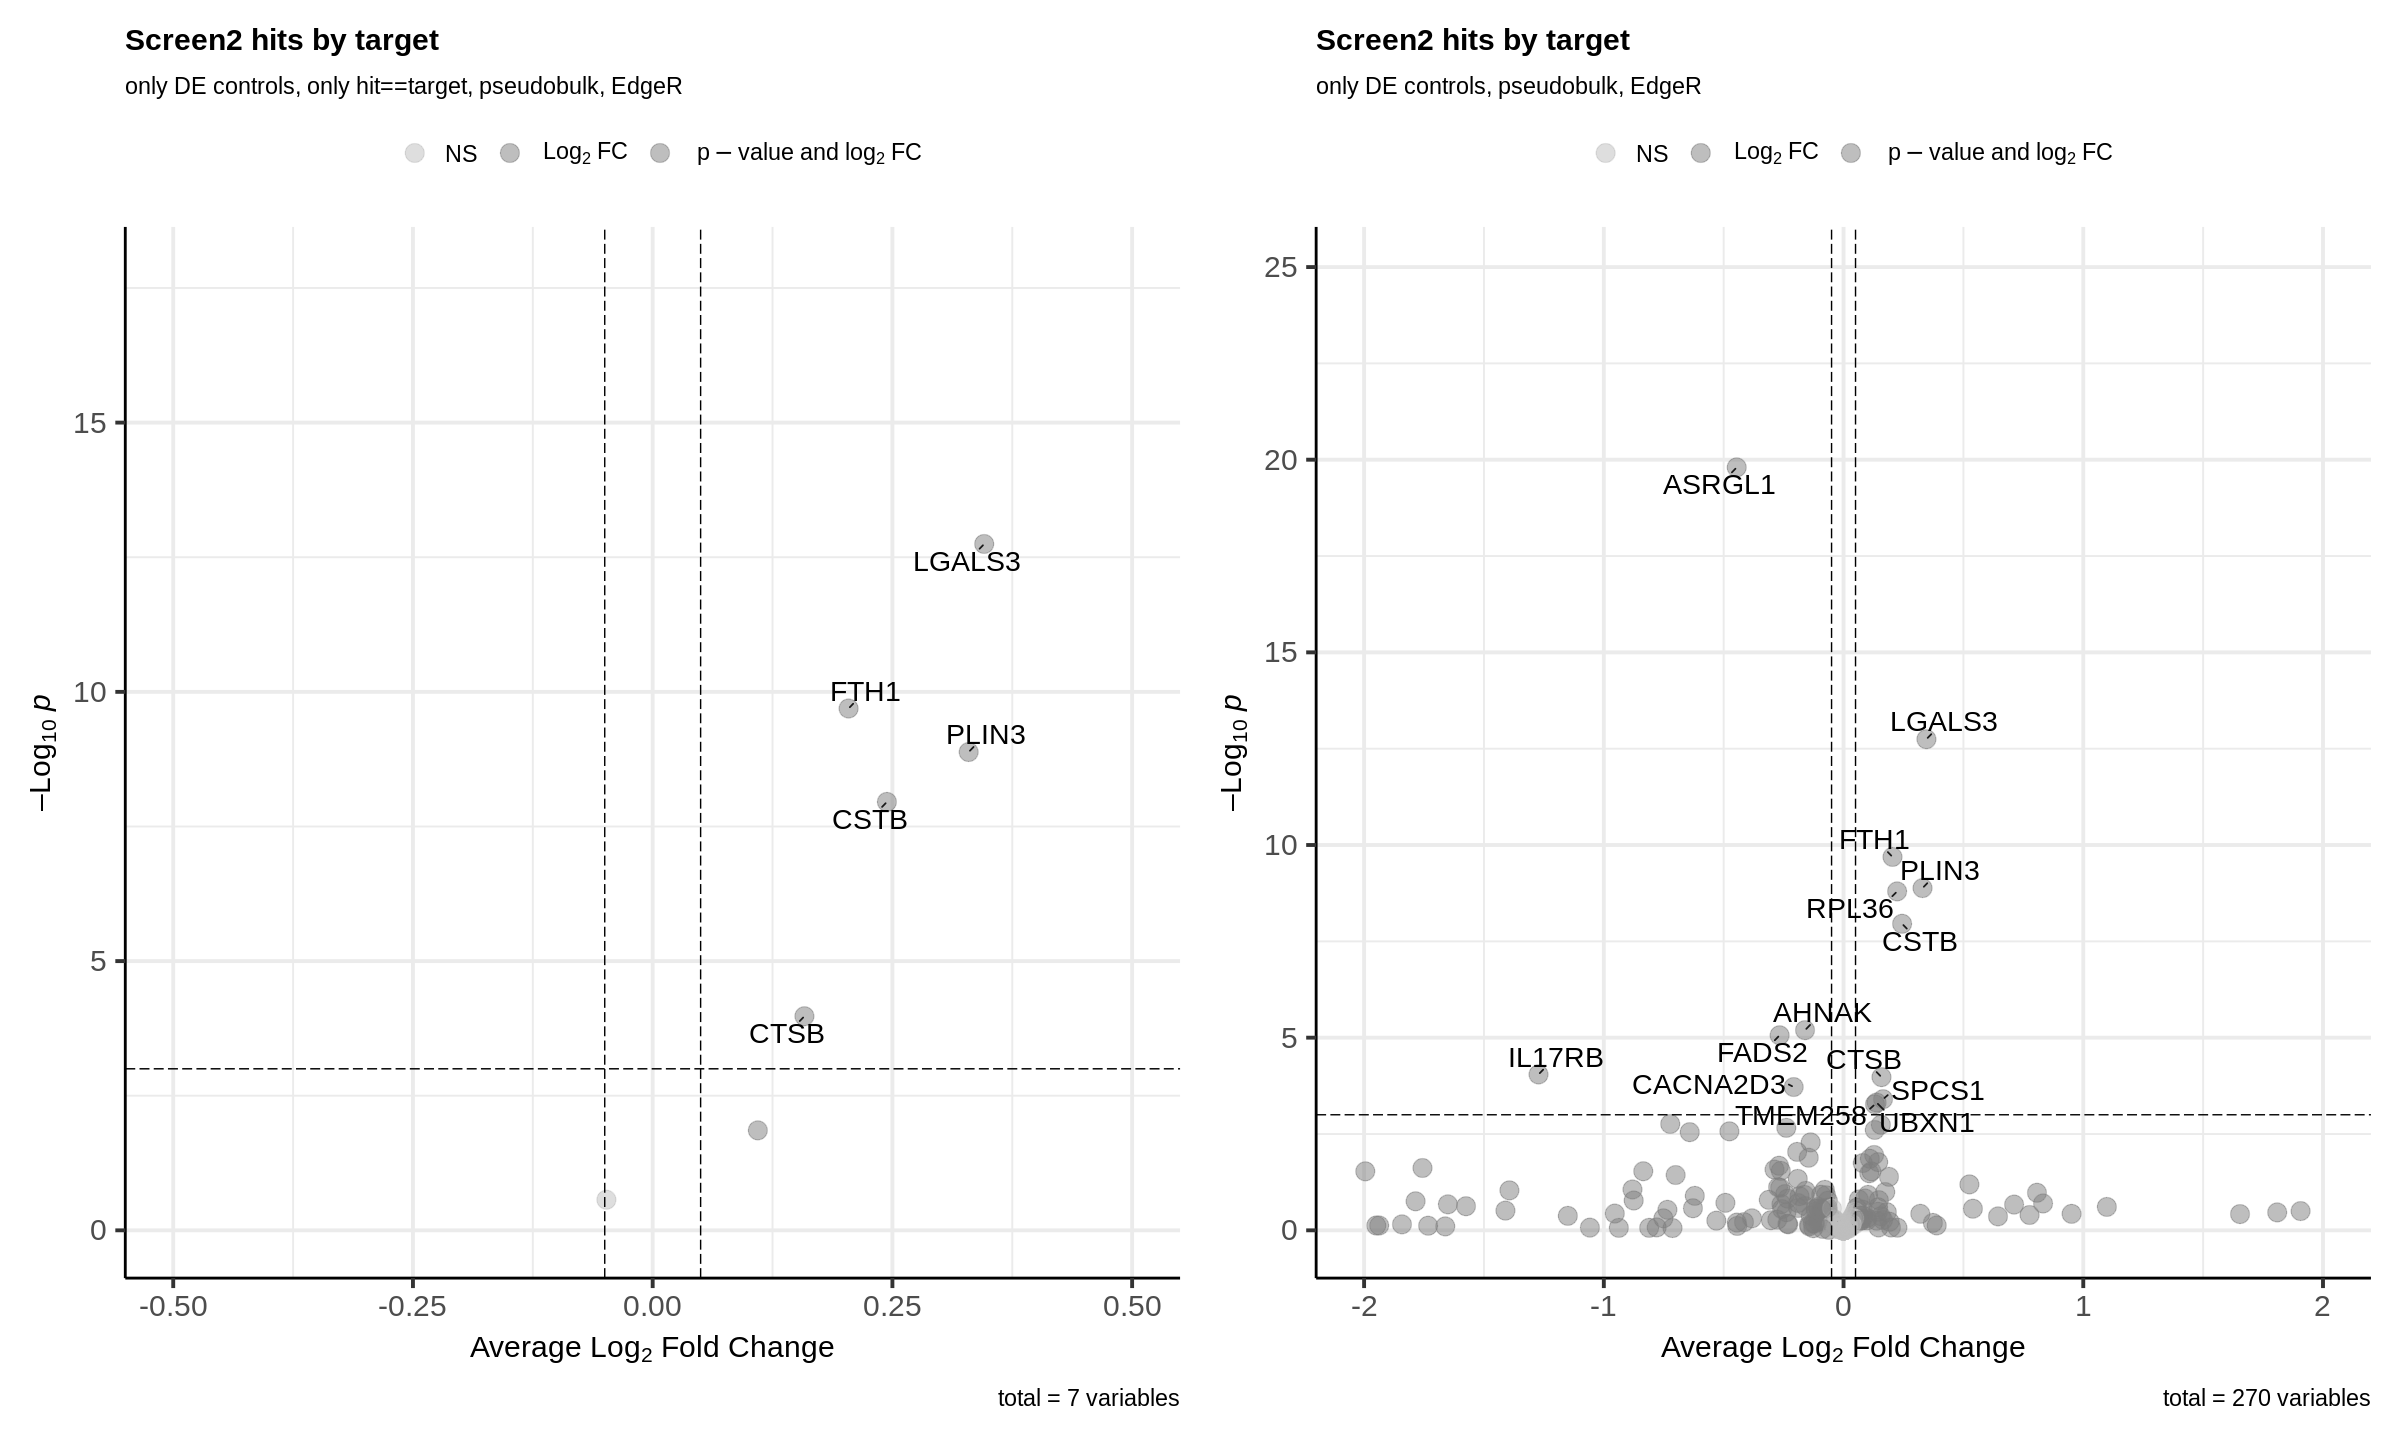

In [ ]:
de_filter = (df_neighbor_de$subclass == 'de_control') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only DE controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-.5, .5) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'de_control')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only DE controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

### Plot just the CKD DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


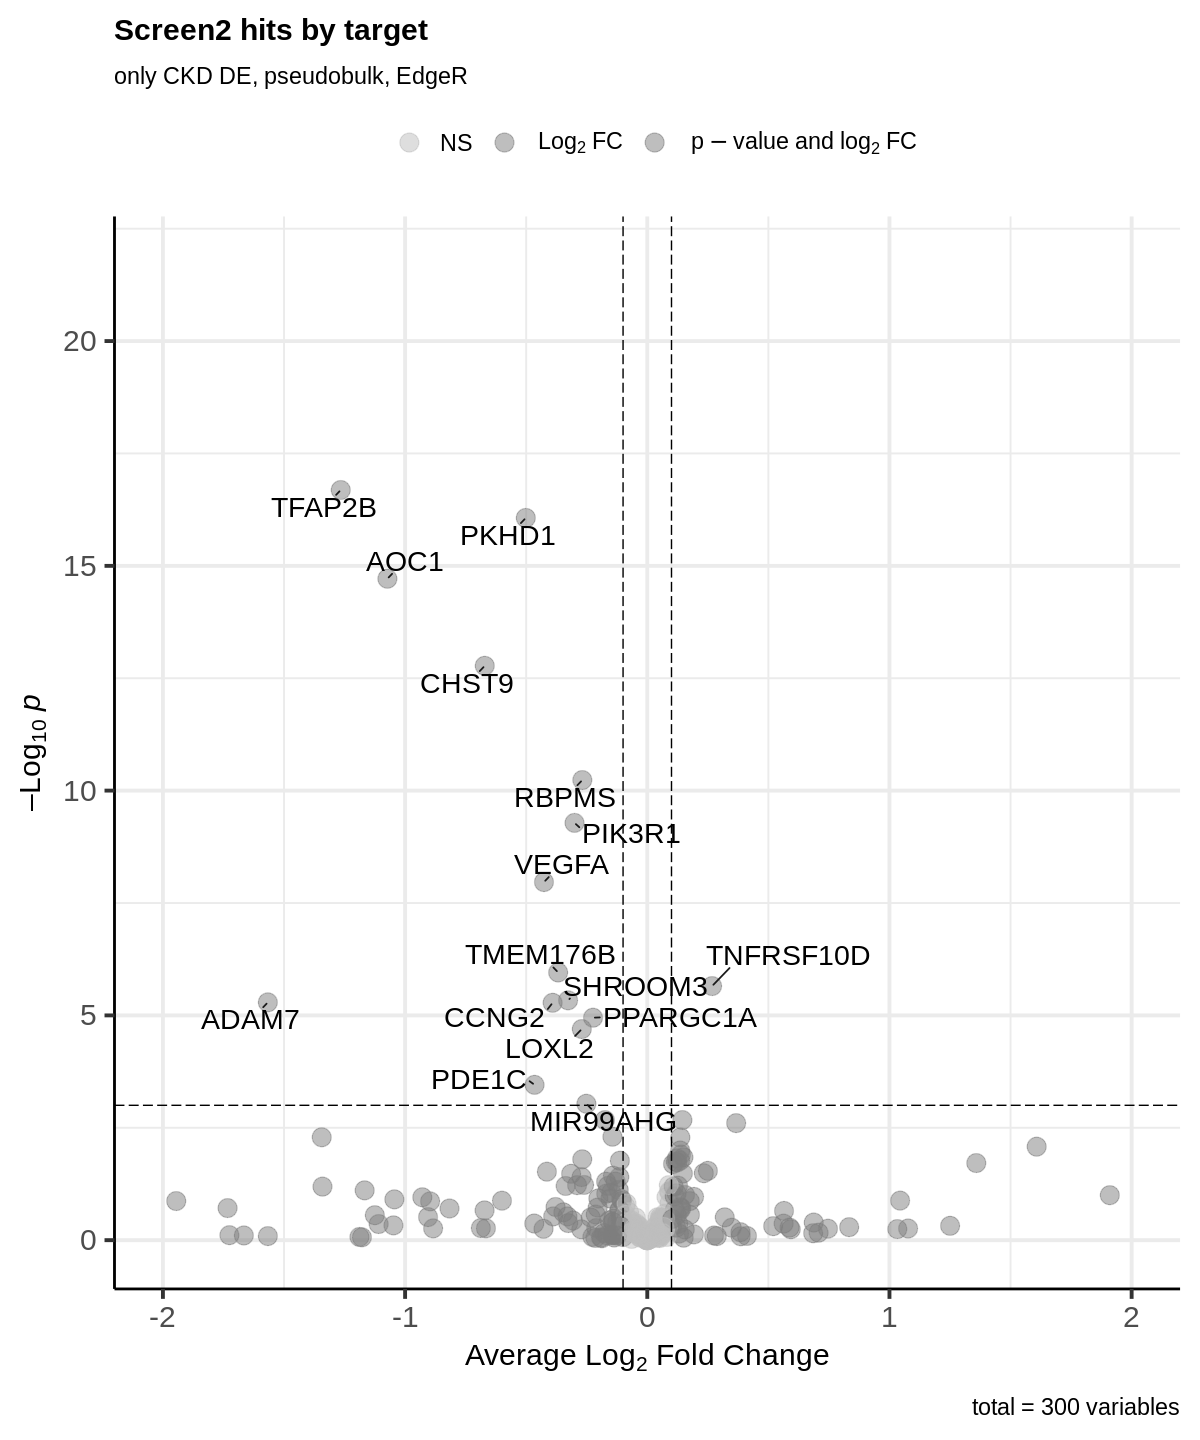

In [ ]:
de_filter = (df_neighbor_de$label == 'CKD DE') 
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 10, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only CKD DE, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.1,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 

# Inspect further

In [ ]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(logFC > 0) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,0.27,5.9,22.4,2.2e-06,TNFRSF10D,DE7,ckd_de,CKD DE
2,4.39,-5.1,9.9,1.7e-03,GIMAP1,DE17,ckd_de,CKD DE
3,0.15,7.1,9.4,2.1e-03,RHEB,DE17,ckd_de,CKD DE
4,0.37,3.3,9.1,2.5e-03,LINC02246,DE1,ckd_de,CKD DE
5,0.14,6.6,7.8,5.2e-03,PPP2CB,DE15,ckd_de,CKD DE
6,1.61,-2.1,7.0,8.3e-03,NOS3,DE17,ckd_de,CKD DE


# Visualize

# Redundant

In [ ]:
cluster_list = as.character(seurat_dummy$perturbation_status)
cluster_list[cluster_list == "target_negative"] = 1
cluster_list[cluster_list == "target_positive"] = 0
seurat_dummy$cluster = as.factor(cluster_list)
y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

In [ ]:
head(y$samples, 10)

,group,lib.size,norm.factors,sample,cluster
,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,1,2.8e+06,1,donor0,0
donor0_cluster1,1,2.3e+08,1,donor0,1
donor1_cluster0,1,7.4e+06,1,donor1,0
donor1_cluster1,1,2.4e+08,1,donor1,1
donor2_cluster0,1,4.9e+06,1,donor2,0
donor2_cluster1,1,2.0e+08,1,donor2,1
donor3_cluster0,1,3.8e+06,1,donor3,0
donor3_cluster1,1,2.0e+08,1,donor3,1


In [ ]:
summary(y$samples$lib.size)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
2.83e+06 4.63e+06 1.02e+08 1.11e+08 2.11e+08 2.37e+08 

In [ ]:
keep.samples <- y$samples$lib.size > 5e4
table(keep.samples)
y <- y[, keep.samples]

keep.samples
TRUE 
   8 

In [ ]:
keep.genes <- filterByExpr(y, group=y$samples$cluster, min.count=10, min.total.count=20)
table(keep.genes)

keep.genes
FALSE  TRUE 
14350 22252 

In [ ]:
y <- normLibSizes(y)
head(y$samples, 10)

,group,lib.size,norm.factors,sample,cluster
,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,1,2.8e+06,1.03,donor0,0
donor0_cluster1,1,2.3e+08,1.00,donor0,1
donor1_cluster0,1,7.4e+06,0.99,donor1,0
donor1_cluster1,1,2.4e+08,1.00,donor1,1
donor2_cluster0,1,4.9e+06,0.98,donor2,0
donor2_cluster1,1,2.0e+08,1.00,donor2,1
donor3_cluster0,1,3.8e+06,1.01,donor3,0
donor3_cluster1,1,2.0e+08,1.00,donor3,1


In [ ]:
summary(y$samples$norm.factors)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.98    0.99    1.00    1.00    1.00    1.03 

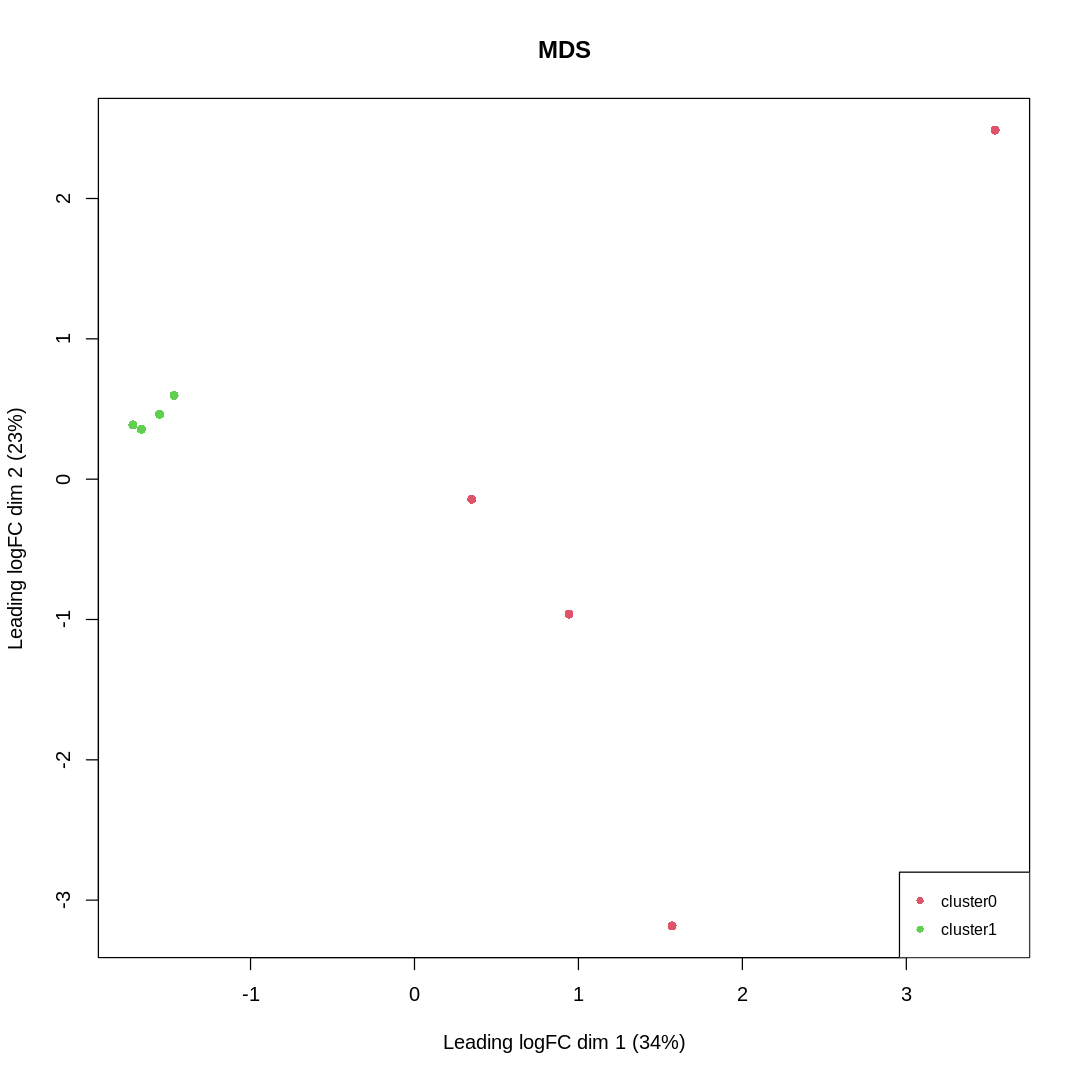

In [ ]:
options(repr.plot.width=9, repr.plot.height=9)
cluster <- as.factor(y$samples$cluster)
plotMDS(y, pch=16, col=c(2:8)[cluster], main="MDS")
legend("bottomright", legend=paste0("cluster",levels(cluster)), pch=16, col=2:8, cex=0.8)

In [ ]:
donor <- factor(y$samples$sample)
design <- model.matrix(~ cluster + donor)
colnames(design) <- gsub("donor", "", colnames(design))
colnames(design)[1] <- "Int"
head(design)

,Int,cluster1,1,2,3
1,1,0,0,0,0
2,1,1,0,0,0
3,1,0,1,0,0
4,1,1,1,0,0
5,1,0,0,1,0
6,1,1,0,1,0


In [ ]:
donor
cluster

[1] donor0 donor0 donor1 donor1 donor2 donor2 donor3 donor3
Levels: donor0 donor1 donor2 donor3

[1] 0 1 0 1 0 1 0 1
Levels: 0 1

[1] 0.0023

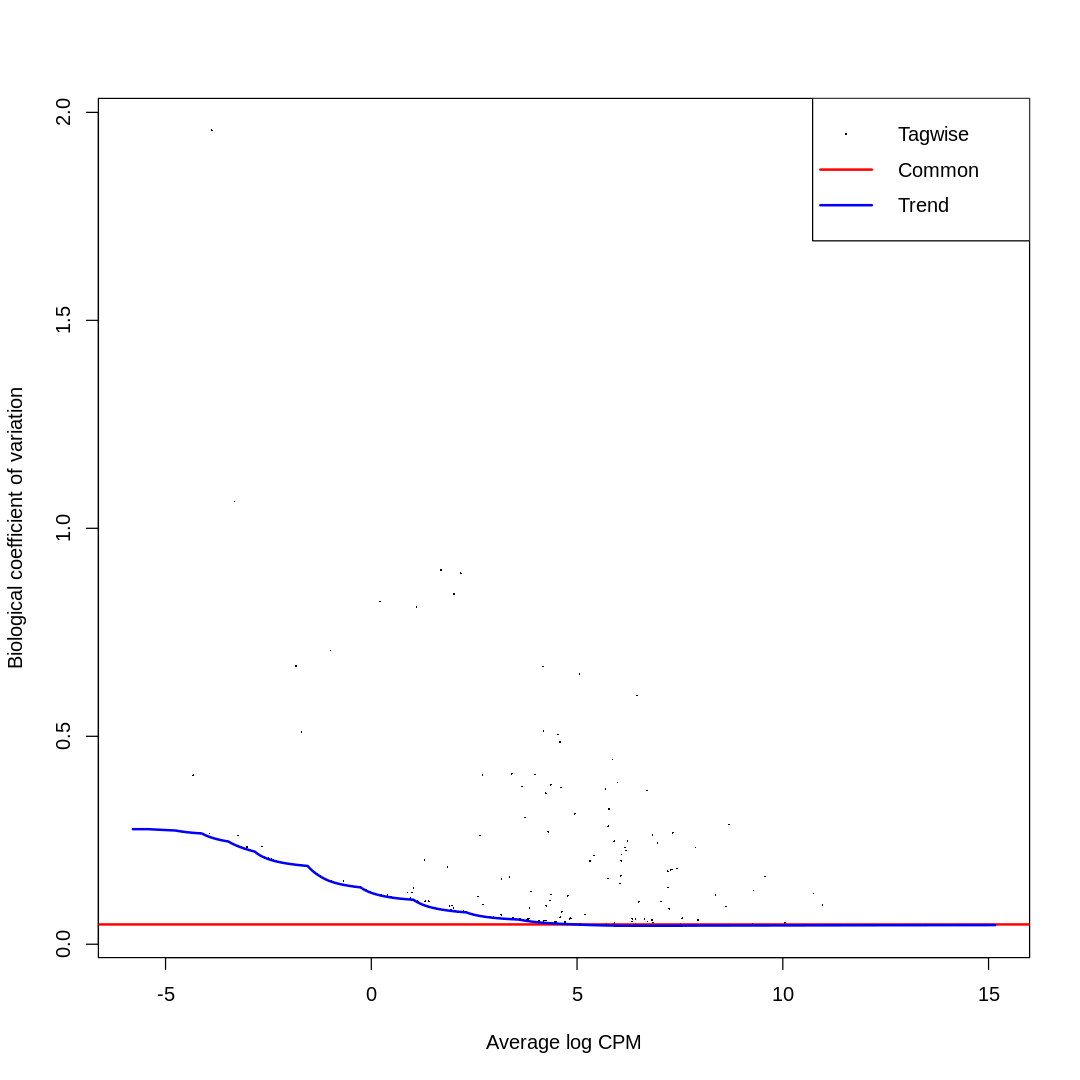

In [ ]:
y <- estimateDisp(y, design, robust=TRUE)
y$common.dispersion

plotBCV(y)

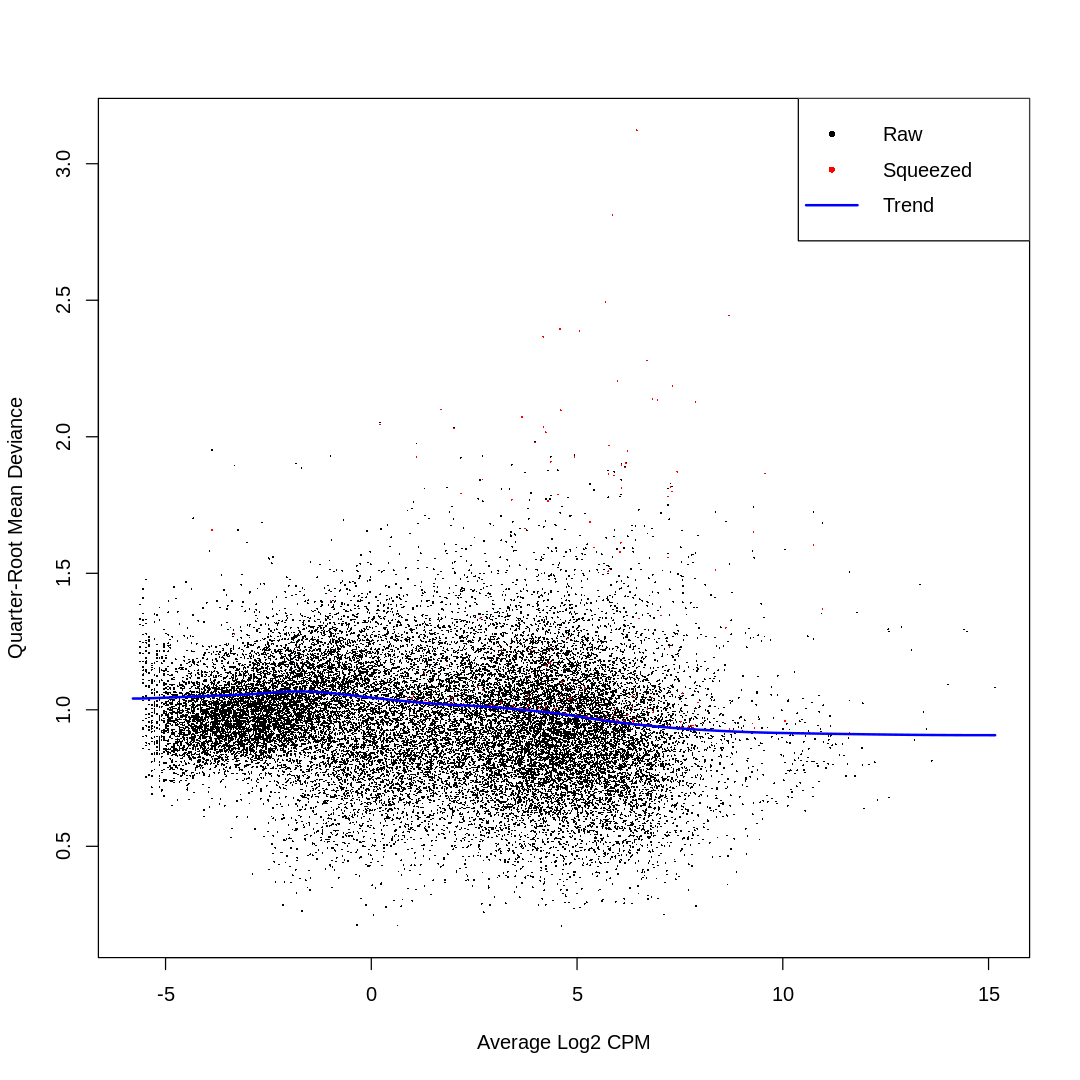

In [ ]:
fit <- glmQLFit(y, design, robust=TRUE)
plotQLDisp(fit)

In [ ]:
ncls <- nlevels(cluster)
contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
diag(contr) <- 1
contr[1,] <- 0
rownames(contr) <- colnames(design)
colnames(contr) <- paste0("cluster", levels(cluster))
contr

,cluster0,cluster1
Int,0,0
cluster1,-1,1
1,0,0
2,0,0
3,0,0


In [ ]:
qlf <- list()
for(i in 1:ncls) {
    qlf[[i]] <- glmQLFTest(fit, contrast=contr[,i])
    qlf[[i]]$comparison <- paste0("cluster", levels(cluster)[i], "_vs_others") 
}

In [ ]:
qlf[[1]]$table[neighbors, ] %>% arrange(PValue)

logFC,logCPM,F,PValue
<dbl>,<dbl>,<dbl>,<dbl>


In [ ]:
dt <- lapply(lapply(qlf, decideTestsDGE), summary)
dt.all <- do.call("cbind", dt)
dt.all

,cluster0_vs_others,cluster1_vs_others
Down,1318,445
NotSig,34839,34839
Up,445,1318


In [ ]:
top <- 20
topMarkers <- list()

for(i in 1:ncls) {
     ord <- order(qlf[[i]]$table$PValue, decreasing=FALSE)
     up <- qlf[[i]]$table$logFC > 0
    topMarkers[[i]] <- rownames(y)[ord[up][1:top]] 
}

topMarkers <- unique(unlist(topMarkers))
topMarkers

[1] "KRT7"       "MMP7"       "SLPI"       "WFDC2"      "TACSTD2"   
 [6] "GDA"        "EPCAM"      "DEPTOR"     "ITGA2"      "TCIM"      
[11] "SLC34A2"    "PKHD1"      "C4orf19"    "LTF"        "KLK6"      
[16] "SLC12A1"    "AC019117.1" "FGF13"      "UGT2A3"     "CDH3"      
[21] "LCN2"       "KRT19"      "MECOM"      "MAL"        "KITLG"     
[26] "MACC1"      "SAA1"       "DCN"        "S100A9"     "PDE1A"     
[31] "ITGB6"      "TSPAN1"     "ARHGEF38"   "BIRC3"      "PCSK5"     
[36] "AL355916.1" "TMPRSS4"    "BST2"       "TFCP2L1"    "NEFL"

In [ ]:
ncls

[1] 2

In [ ]:
qlf[[1]]$table %>% filter(logFC < 0) %>% arrange(PValue)

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
LCN2,-3.54,5.2,849,1.9e-185
KRT19,-1.40,7.9,847,4.8e-159
KRT7,-1.85,5.7,585,5.4e-129
MMP7,-1.19,7.6,596,1.1e-116
SLPI,-0.90,9.4,476,2.6e-105
MECOM,-1.39,6.8,595,7.6e-98
WFDC2,-1.46,7.8,869,3.2e-97
MAL,-1.42,5.5,348,1.0e-74
KITLG,-1.67,5.0,318,5.8e-71


In [ ]:
qlf[[1]]$table['ANPEP',]

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
ANPEP,-0.2,7.3,18,2e-05


## Check using Seurat FindMarkers

In [ ]:
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.1

markers <- FindMarkers(
    object = seurat_dummy,
    features = neighbors,
    slot = "data",
    ident.1 = 'target_positive',
    ident.2 = 'target_negative',
    test.use = test_use,
    logfc.threshold = logfc_threshold,
    latent.vars = c("library", "donor"),
    only.pos = FALSE, 
    verbose = FALSE
)


In [ ]:
markers

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dCas9,1.2e-69,0.82,0.84,0.44,4.4e-65
FTL,3.7e-50,0.52,1.00,1.00,1.4e-45
MMP7,9.2e-35,-0.78,0.54,0.69,3.4e-30
SLPI,2.6e-34,-0.86,0.68,0.81,9.3e-30
MT-ND1,1.2e-33,-0.32,1.00,1.00,4.2e-29
RPL36,1.4e-30,0.25,0.99,0.98,5.0e-26
KRT19,2.0e-29,-0.85,0.46,0.59,7.2e-25
WFDC2,3.5e-29,-1.01,0.31,0.44,1.3e-24
RPL13,2.0e-25,0.25,1.00,1.00,7.2e-21


In [ ]:
head(counts@.Data)

                           
1 function (object, ...)   
2 standardGeneric("counts")

In [ ]:
y

,donor0_cluster0,donor0_cluster1,donor1_cluster0,donor1_cluster1,donor2_cluster0,donor2_cluster1,donor3_cluster0,donor3_cluster1
MIR1302-2HG,0,4,0,4,0,2,0,2
FAM138A,0,0,0,0,0,0,0,0
OR4F5,1,1,0,6,0,4,0,0
AL627309.1,1,96,2,69,3,62,1,60
AL627309.3,1,6,0,6,0,3,0,3
AL627309.2,0,0,0,1,0,1,0,0
AL627309.5,3,153,1,158,6,114,3,143
AL627309.4,0,0,0,4,0,2,0,0
AP006222.2,0,0,0,1,0,1,0,3
AL732372.1,0,0,0,0,0,1,0,0


In [ ]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01

for(i in 1:nrow(df_targets)) {
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        ckd_de = 
        neighbors = neighbors_list[[target]]
    } else {
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neighbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    seurat_dummy$perturbation_status = Idents(seurat_dummy)
    seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
    print(table(filter(seurat_dummy@meta.data, perturbation_status == 'target_positive')$donor) )

    # Use each donor as a replicate
    cluster_list = as.character(seurat_dummy$perturbation_status)
    cluster_list[cluster_list == "target_negative"] = 1
    cluster_list[cluster_list == "target_positive"] = 0
    seurat_dummy$cluster = as.factor(cluster_list)
    y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')
    break
}

ANPEP ANPEP : CD13-1a,CD13-1b 
CD13-1a   390 
CD13-1b   564 
Guide+ = 564 ; Guide- = 45487 

donor0 donor1 donor2 donor3 
   127    179    145    113 


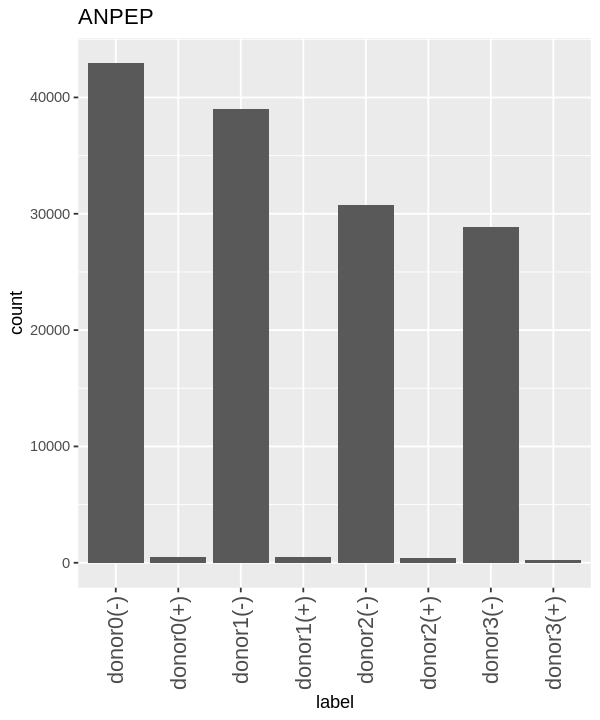

In [ ]:
options(repr.plot.width=5, repr.plot.height=6)
df_dummy = as.data.frame(y$count[target,])
colnames(df_dummy) <- target
df_dummy$label = rownames(df_dummy)
rownames(df_dummy) <- NULL
df_dummy$label = str_replace(df_dummy$label, "_cluster0", "(+)")
df_dummy$label = str_replace(df_dummy$label, "_cluster1", "(-)")
#df_dummy = t(df_dummy)
#labels = colnames(df_dummy)

ggplot(df_dummy, aes(label)) +
     geom_bar(aes(weight=get(target))) +
     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 13)) +
     labs(title=target)

In [ ]:
head(df_cell_counts)

,Row.names,count,target,label,group,lib.size,norm.factors,sample,cluster,norm_count
,<I<chr>>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,donor0_cluster0,535,ANPEP,donor0(+),1,2.9e+06,1,donor0,0,44523
2,donor0_cluster1,42941,ANPEP,donor0(-),1,2.3e+08,1,donor0,1,44359
3,donor1_cluster0,480,ANPEP,donor1(+),1,4.0e+06,1,donor1,0,29228
4,donor1_cluster1,38983,ANPEP,donor1(-),1,2.4e+08,1,donor1,1,39110
5,donor2_cluster0,438,ANPEP,donor2(+),1,3.0e+06,1,donor2,0,34742
6,donor2_cluster1,30783,ANPEP,donor2(-),1,2.1e+08,1,donor2,1,36166


In [ ]:
df_cell_counts

Row.names,count,target,label,group,lib.size,norm.factors,sample,cluster,norm_count
<I<chr>>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
donor0_cluster0,535,ANPEP,donor0(+),1,2.9e+06,1,donor0,0,44523
donor0_cluster1,42941,ANPEP,donor0(-),1,2.3e+08,1,donor0,1,44359
donor1_cluster0,480,ANPEP,donor1(+),1,4.0e+06,1,donor1,0,29228
donor1_cluster1,38983,ANPEP,donor1(-),1,2.4e+08,1,donor1,1,39110
donor2_cluster0,438,ANPEP,donor2(+),1,3.0e+06,1,donor2,0,34742
donor2_cluster1,30783,ANPEP,donor2(-),1,2.1e+08,1,donor2,1,36166
donor3_cluster0,254,ANPEP,donor3(+),1,2.0e+06,1,donor3,0,30741
donor3_cluster1,28849,ANPEP,donor3(-),1,2.0e+08,1,donor3,1,35234
donor0_cluster0,51,CD55,donor0(+),1,1.7e+06,1,donor0,0,7312


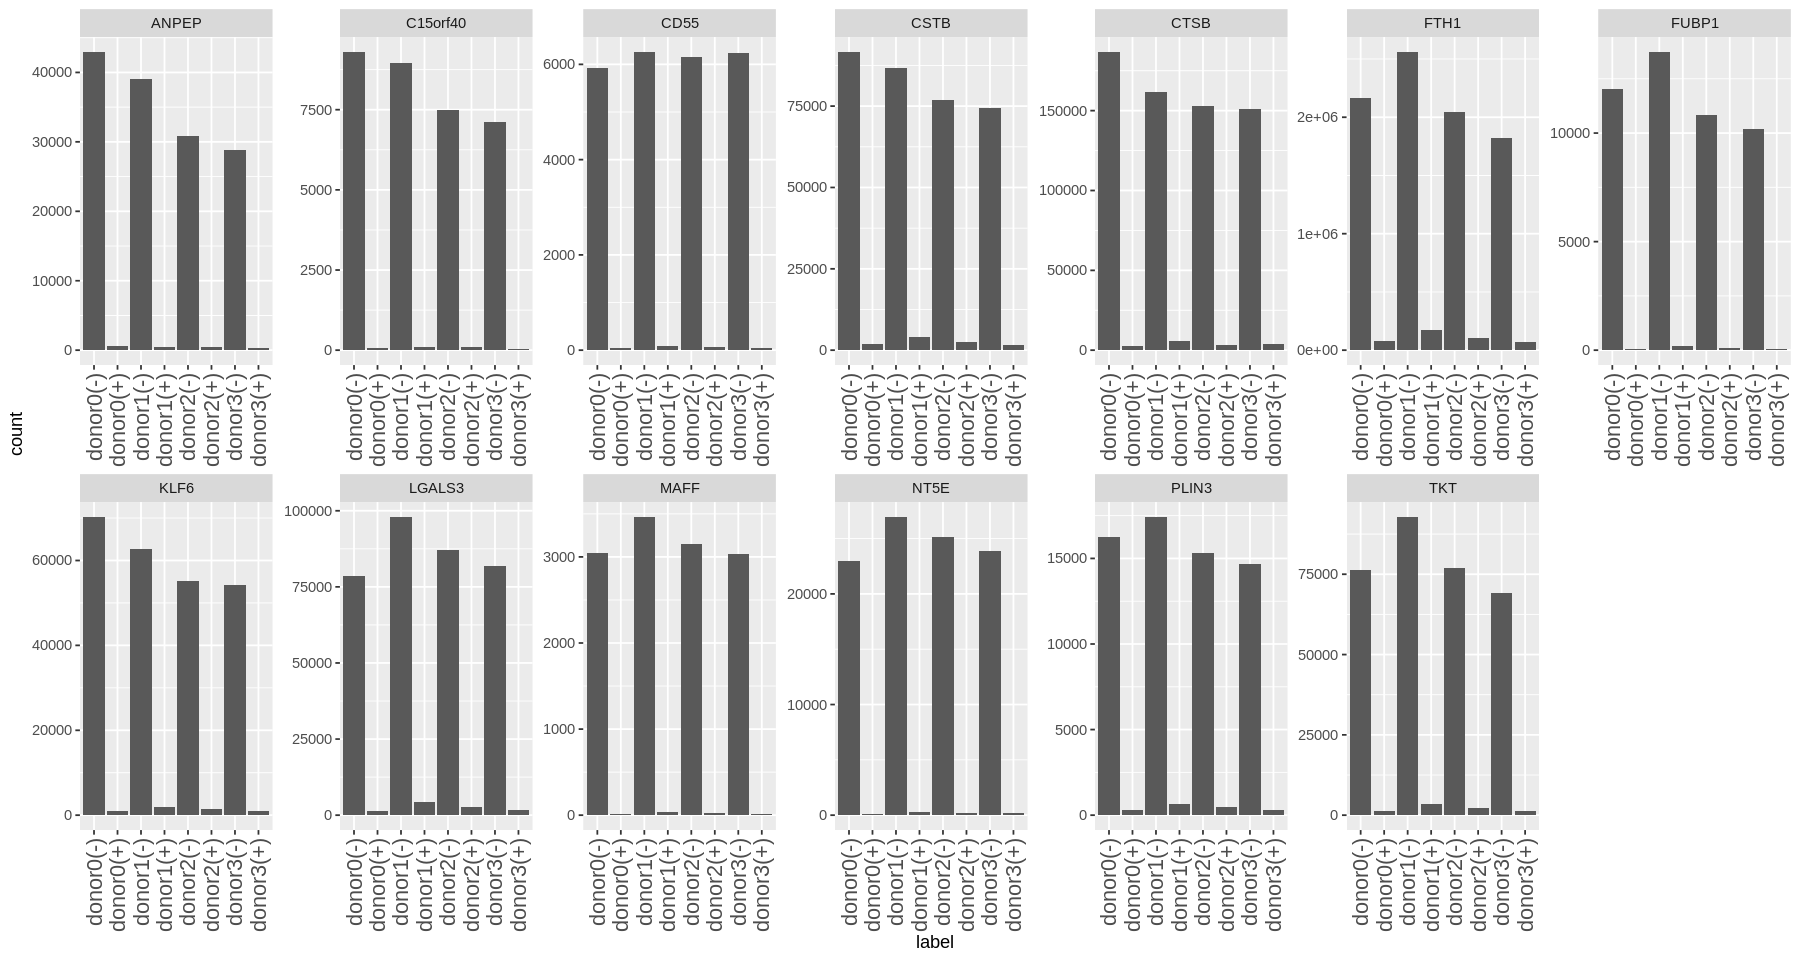

In [ ]:

options(repr.plot.width=15, repr.plot.height=8)
ggplot(df_cell_counts, aes(label)) +
    geom_bar(aes(weight=count)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 13)) +
    facet_wrap(~ target, scales="free", ncol = 7)
     

In [ ]:
y$counts[target,]

donor0_cluster0 donor0_cluster1 donor1_cluster0 donor1_cluster1 donor2_cluster0 
            535           42941             480           38983             438 
donor2_cluster1 donor3_cluster0 donor3_cluster1 
          30783             254           28849

In [ ]:
head(df_cell_counts)

,Row.names,count,target,label,group,lib.size,norm.factors,sample,cluster,norm_count
,<I<chr>>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,donor0_cluster0,535,ANPEP,donor0(+),1,2.9e+06,1,donor0,0,44523
2,donor0_cluster1,42941,ANPEP,donor0(-),1,2.3e+08,1,donor0,1,44359
3,donor1_cluster0,480,ANPEP,donor1(+),1,4.0e+06,1,donor1,0,29228
4,donor1_cluster1,38983,ANPEP,donor1(-),1,2.4e+08,1,donor1,1,39110
5,donor2_cluster0,438,ANPEP,donor2(+),1,3.0e+06,1,donor2,0,34742
6,donor2_cluster1,30783,ANPEP,donor2(-),1,2.1e+08,1,donor2,1,36166


In [ ]:
log(388/24813, 10)

[1] -1.8

In [ ]:
head(df_neighbor_de)

NULL

In [ ]:
donor
cluster

[1] donor0 donor0 donor1 donor1 donor2 donor2 donor3 donor3
Levels: donor0 donor1 donor2 donor3

[1] 0 1 0 1 0 1 0 1
Levels: 0 1

In [ ]:
design

,Int,cluster1,1,2,3
1,1,0,0,0,0
2,1,1,0,0,0
3,1,0,1,0,0
4,1,1,1,0,0
5,1,0,0,1,0
6,1,1,0,1,0
7,1,0,0,0,1
8,1,1,0,0,1


In [ ]:
table(Idents(seurat_dummy))


target_positive target_negative 
            564           45487 

In [ ]:
as.data.frame(table(seurat_dummy@meta.data[,c('perturbation_status','donor')]))

perturbation_status,donor,Freq
<fct>,<fct>,<int>
target_positive,donor0,127
target_negative,donor0,11642
target_positive,donor1,179
target_negative,donor1,12076
target_positive,donor2,145
target_negative,donor2,11044
target_positive,donor3,113
target_negative,donor3,10725


In [ ]:
head(df_cell_counts)

,Row.names,count,target,label,group,lib.size,norm.factors,sample,cluster,norm_count
,<I<chr>>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,donor0_cluster0,535,ANPEP,donor0(+),1,2.9e+06,1,donor0,0,44523
2,donor0_cluster1,42941,ANPEP,donor0(-),1,2.3e+08,1,donor0,1,44359
3,donor1_cluster0,480,ANPEP,donor1(+),1,4.0e+06,1,donor1,0,29228
4,donor1_cluster1,38983,ANPEP,donor1(-),1,2.4e+08,1,donor1,1,39110
5,donor2_cluster0,438,ANPEP,donor2(+),1,3.0e+06,1,donor2,0,34742
6,donor2_cluster1,30783,ANPEP,donor2(-),1,2.1e+08,1,donor2,1,36166


In [ ]:
y$samples

,group,lib.size,norm.factors,sample,cluster
,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,1,2.9e+06,1,donor0,0
donor0_cluster1,1,2.3e+08,1,donor0,1
donor1_cluster0,1,4.0e+06,1,donor1,0
donor1_cluster1,1,2.4e+08,1,donor1,1
donor2_cluster0,1,3.0e+06,1,donor2,0
donor2_cluster1,1,2.1e+08,1,donor2,1
donor3_cluster0,1,2.0e+06,1,donor3,0
donor3_cluster1,1,2.0e+08,1,donor3,1


In [ ]:
df_dummy = as.data.frame(y$counts[target,])
colnames(df_dummy) = "count"
df_dummy$target <- target
df_dummy$label = rownames(df_dummy)
df_samples = y$samples


In [ ]:
df_dummy

,count,target,label
,<dbl>,<chr>,<chr>
donor0_cluster0,535,ANPEP,donor0_cluster0
donor0_cluster1,42941,ANPEP,donor0_cluster1
donor1_cluster0,480,ANPEP,donor1_cluster0
donor1_cluster1,38983,ANPEP,donor1_cluster1
donor2_cluster0,438,ANPEP,donor2_cluster0
donor2_cluster1,30783,ANPEP,donor2_cluster1
donor3_cluster0,254,ANPEP,donor3_cluster0
donor3_cluster1,28849,ANPEP,donor3_cluster1


In [ ]:
df_samples

,group,lib.size,norm.factors,sample,cluster
,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,1,2.9e+06,1,donor0,0
donor0_cluster1,1,2.3e+08,1,donor0,1
donor1_cluster0,1,4.0e+06,1,donor1,0
donor1_cluster1,1,2.4e+08,1,donor1,1
donor2_cluster0,1,3.0e+06,1,donor2,0
donor2_cluster1,1,2.1e+08,1,donor2,1
donor3_cluster0,1,2.0e+06,1,donor3,0
donor3_cluster1,1,2.0e+08,1,donor3,1


In [ ]:
 merge(df_dummy, df_samples, by = 0)

Row.names,count,target,label,group,lib.size,norm.factors,sample,cluster
<I<chr>>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,535,ANPEP,donor0_cluster0,1,2.9e+06,1,donor0,0
donor0_cluster1,42941,ANPEP,donor0_cluster1,1,2.3e+08,1,donor0,1
donor1_cluster0,480,ANPEP,donor1_cluster0,1,4.0e+06,1,donor1,0
donor1_cluster1,38983,ANPEP,donor1_cluster1,1,2.4e+08,1,donor1,1
donor2_cluster0,438,ANPEP,donor2_cluster0,1,3.0e+06,1,donor2,0
donor2_cluster1,30783,ANPEP,donor2_cluster1,1,2.1e+08,1,donor2,1
donor3_cluster0,254,ANPEP,donor3_cluster0,1,2.0e+06,1,donor3,0
donor3_cluster1,28849,ANPEP,donor3_cluster1,1,2.0e+08,1,donor3,1


In [ ]:
head(df_cell_counts)

,Row.names,count,target,label,group,lib.size,norm.factors,sample,cluster,norm_count
,<I<chr>>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,donor0_cluster0,535,ANPEP,donor0(+),1,2.9e+06,1,donor0,0,44523
2,donor0_cluster1,42941,ANPEP,donor0(-),1,2.3e+08,1,donor0,1,44359
3,donor1_cluster0,480,ANPEP,donor1(+),1,4.0e+06,1,donor1,0,29228
4,donor1_cluster1,38983,ANPEP,donor1(-),1,2.4e+08,1,donor1,1,39110
5,donor2_cluster0,438,ANPEP,donor2(+),1,3.0e+06,1,donor2,0,34742
6,donor2_cluster1,30783,ANPEP,donor2(-),1,2.1e+08,1,donor2,1,36166


In [ ]:
df_cell_counts$norm_counts = max(df_cell_counts$lib.size) * df_cell_counts$count/df_cell_counts$lib.size

In [ ]:
head(df_cell_counts)

,Row.names,count,target,label,group,lib.size,norm.factors,sample,cluster,norm_count,norm_counts
,<I<chr>>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,donor0_cluster0,535,ANPEP,donor0(+),1,2.9e+06,1,donor0,0,44523,44523
2,donor0_cluster1,42941,ANPEP,donor0(-),1,2.3e+08,1,donor0,1,44359,44359
3,donor1_cluster0,480,ANPEP,donor1(+),1,4.0e+06,1,donor1,0,29228,29228
4,donor1_cluster1,38983,ANPEP,donor1(-),1,2.4e+08,1,donor1,1,39110,39110
5,donor2_cluster0,438,ANPEP,donor2(+),1,3.0e+06,1,donor2,0,34742,34742
6,donor2_cluster1,30783,ANPEP,donor2(-),1,2.1e+08,1,donor2,1,36166,36166


In [ ]:
design

,Int,cluster1,1,2,3
1,1,0,0,0,0
2,1,1,0,0,0
3,1,0,1,0,0
4,1,1,1,0,0
5,1,0,0,1,0
6,1,1,0,1,0
7,1,0,0,0,1
8,1,1,0,0,1
